In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sbs
import scipy
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from conflab_gendata import Feeder_conflab, gendata_from_feeder

In [4]:
data_path = '/mnt/e/data/conflab/pose_v2'
label_path = '/mnt/e/data/conflab/speaking_status'
max_frame = 300

In [5]:
feeder = Feeder_conflab(
        data_path=data_path,
        label_path=label_path,
        window_size=max_frame)

32it [01:14,  2.32s/it]
8it [00:06,  1.25it/s]


# occlusion stats

In [8]:
feeder.segments[0].keys()

dict_keys(['cam', 'vid', 'seg', 'tracks'])

In [9]:
# 0: frame num
# 1-35: skeleton
# 35-52: occlusion
feeder.segments[0]['tracks'][1]

KeyError: 1

# Occlusion over the image plane for different body parts

In [10]:
keypoint_sets = [
    [0,1,2,3,6],                # upper body
    [9,10,11,12,13,14,15,16],   # lower body
    [4,5,7,8]                   # arms
]



In [11]:
# create ndarray with (x,y,oclussion) per keypoint
keypoints_occlusion = [[] for i in range(17)]
for seg in feeder.segments:
    for pid, track in seg['tracks'].items():
        for i in range(0,17):
            xy = track[:, 1+i*2 : 1+i*2+2]
            occl = track[:, 35+i][:,None]

            keypoints_occlusion[i].append(np.hstack([xy, occl]))

agg_occlusion = [np.vstack(kps) for kps in keypoints_occlusion]
agg_occlusion = [df[~np.isnan(df).any(axis=1)] for df in agg_occlusion]

In [12]:
agg_occlusion[15][:10,:]

array([[0.44718259, 0.45959596, 0.        ],
       [0.44628101, 0.46127946, 0.        ],
       [0.44628101, 0.46127946, 0.        ],
       [0.44628101, 0.46127946, 0.        ],
       [0.44628101, 0.46127946, 0.        ],
       [0.44628101, 0.46127946, 0.        ],
       [0.44628101, 0.46127946, 0.        ],
       [0.44628101, 0.46127946, 0.        ],
       [0.44628101, 0.46127946, 0.        ],
       [0.44628101, 0.46127946, 0.        ]])

In [13]:
feet_arr = np.vstack([agg_occlusion[i] for i in [15,16]])
head_arr = agg_occlusion[0]

In [14]:
head_stat, _, _, _ = scipy.stats.binned_statistic_2d(
    x=head_arr[:,0], 
    y=head_arr[:,1], 
    values=head_arr[:,2], 
    bins=[20,20],
    range=[[0,1],[0,1]],
    statistic='mean')

In [25]:
feet_stat, _, _, _ = scipy.stats.binned_statistic_2d(
    x=feet_arr[:,0], 
    y=feet_arr[:,1], 
    values=feet_arr[:,2], 
    bins=[40,40],
    range=[[0,1],[0,1]],
    statistic='mean')

In [16]:
head_stat[:2,:2]

array([[6.18162743e-01, 1.19397218e-01],
       [6.49818806e-01, 2.79524808e-05]])

In [17]:
feet_stat[:3,:3]

array([[0.9487455 ,        nan,        nan],
       [1.        , 1.        ,        nan],
       [0.9509018 , 0.20994475, 1.        ]])

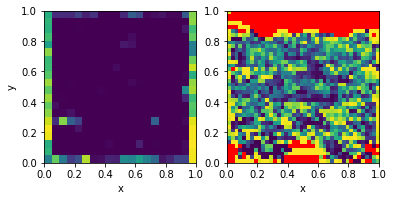

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(head_stat, cmap='viridis', extent=[0,1,0,1])
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.imshow(feet_stat, cmap='viridis', extent=[0,1,0,1])
ax2.set_xlabel('x')

current_cmap = matplotlib.cm.get_cmap().copy()
current_cmap.set_bad(color='red')

In [108]:
fig.savefig('occlusion_imgplane.png', dpi=300, bbox_inches='tight')

In [56]:
sbs.histplot(data=df_head, x='x', y='y', bins=10, binrange=[0.0,1.0], weights='occlusion')

BinnedStatistic2dResult(statistic=array([[6.18162743e-01, 1.19397218e-01, 1.28081365e-01, 1.22771268e-01,
        1.95876289e-01, 8.93641957e-02, 1.41762933e-01, 4.59434061e-03,
        0.00000000e+00, 0.00000000e+00, 1.09331197e-01, 2.93508175e-01,
        2.20064725e-01, 1.71208945e-02, 3.54941154e-02, 5.19734781e-02,
        1.81558548e-02, 1.48403538e-02, 2.76904832e-01, 8.09554015e-01],
       [6.49818806e-01, 2.79524808e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.16903146e-04, 8.24624257e-01],
       [6.35492316e-01, 3.39251385e-04, 0.00000000e+00, 0.00000000e+00,
        4.81283422e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

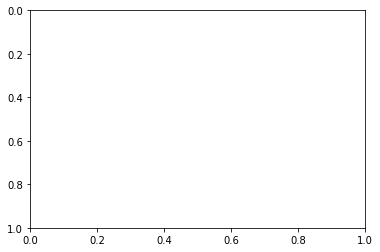

In [8]:
occlusion_per_joint = np.zeros((17))
totals_per_joint = np.zeros((17), dtype=int)
for seg in feeder.segments:
    for pid, track in seg['tracks'].items():
        occlusion_data = track[:,-17:]

        has_occlusion = occlusion_data.copy()
        has_occlusion[has_occlusion != None] = 1
        has_occlusion[has_occlusion == None] = 0
        # print(np.sum(has_occlusion, axis=0))
        totals_per_joint = totals_per_joint + np.sum(has_occlusion, axis=0)


        has_positive_occlusion = occlusion_data.copy()
        has_positive_occlusion[has_positive_occlusion != 1] = 0
        occlusion_per_joint = occlusion_per_joint + np.sum(has_positive_occlusion, axis=0)

In [9]:
occlusion_per_joint

array([1062093.0, 1846553.0, 1943151.0, 1203790.0, 1525221.0, 1624206.0,
       1146377.0, 1520926.0, 1635187.0, 1825415.0, 2092482.0, 1916887.0,
       1780947.0, 1898989.0, 1928590.0, 1877012.0, 1846075.0],
      dtype=object)

In [10]:
totals_per_joint

array([3763390.0, 3628083.0, 3412835.0, 3747161.0, 3448178.0, 3476960.0,
       3450936.0, 3461919.0, 3505084.0, 3462530.0, 3441631.0, 3503150.0,
       3470407.0, 3456021.0, 3546396.0, 3828826.0, 3857605.0],
      dtype=object)

In [11]:
occlusion_per_joint / totals_per_joint

array([0.28221709681962276, 0.5089610684209815, 0.5693656446912904,
       0.3212538772686842, 0.4423266432301349, 0.467133933090976,
       0.332193062983492, 0.4393303251751413, 0.4665186340755314,
       0.5271911001493128, 0.6079913854797333, 0.5471895294235188,
       0.5131810188257458, 0.5494726449868216, 0.5438168777542045,
       0.4902317316065029, 0.4785546990943863], dtype=object)

# turn length & confidence stats

In [6]:
def apply_mpd(ss, mpd = 2):
    mpd_ss = ss.copy()
    pauses = []
    indices = np.where(np.diff(ss) != 0)[0]
    prev_index = 0
    for idx in indices:
        if ss[idx] == 0:
            pauses.append([prev_index, idx])
        prev_index = idx

    for pause in pauses:
        if pause[1] - pause[0] < mpd:
            mpd_ss[pause[0]+1:pause[1]+1] = 1
    return mpd_ss

In [7]:
test = np.array([1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1])
test

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [8]:
apply_mpd(test)

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
def get_frame_ss(ss):
    # zero out lines with no frame
    ss.loc[ss['index'] == 0, 'data0'] = np.nan
    ss = ss['data0'].to_numpy()

    last_status = 0
    for i in range(len(ss)):
        if np.isnan(ss[i]):
            ss[i] = last_status
        else:
            last_status = ss[i]
    return ss

In [10]:
def get_turns(ss):
    turns = []
    indices = np.where(np.diff(ss) != 0)[0]
    prev_index = 0
    for idx in indices:
        if ss[idx] == 1:
            turns.append([prev_index, idx])
        prev_index = idx
    return turns

In [11]:
def get_confidence(sig):
    sig = sig[sig['index'] != 0]
    conf = sig['data0'].to_numpy()
    return conf

In [12]:
def get_turn_confidence(turn, confidence_df):
    if confidence_df is None:
        return np.nan

    confidence_arr = confidence_df['data0'].to_numpy()
    turn_conf = confidence_arr[turn[0]: turn[1]]
    return np.nanmean(turn_conf)

In [13]:
test = np.array([1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1])
test

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [14]:
get_turns(test)

[[0, 1], [4, 7], [10, 13]]

In [28]:
occlusion_per_joint = np.zeros((17))
totals_per_joint = np.zeros((17), dtype=int)
turn_lengths = {}
turn_confidences = []
confidences = []
for seg, seg_data in feeder.labels.items():
    for pid, pid_data in seg_data.items():
        if pid not in turn_lengths:
            turn_lengths[pid] = []

        ss = get_frame_ss(pid_data['ss'])
        mpd_data = apply_mpd(ss)
        turns = get_turns(mpd_data)
        tl = [t[1] - t[0] for t in turns]
        turn_lengths[pid] = [*turn_lengths[pid], *tl]
        
        # turn confidences
        tc = [get_turn_confidence(t, pid_data['conf']) for t in turns]
        turn_confidences = [*turn_confidences, *tc]
        
        if pid_data['conf'] is None:
            print(f'pid_data is None')
            continue
        confidences.append(get_confidence(pid_data['conf']))
for pid in turn_lengths.keys():
    turn_lengths[pid] = np.array(turn_lengths[pid]) / 60
all_turn_lengths = np.concatenate(list(turn_lengths.values()))
# turn_lengths = np.array(turn_lengths) / 60
confidences = np.concatenate(confidences)

pid_data is None
pid_data is None
pid_data is None
pid_data is None
pid_data is None
pid_data is None
pid_data is None
pid_data is None


In [29]:
(len(all_turn_lengths), len(turn_confidences))

(4098, 4098)

[(0.0, 20.0),
 Text(0.5, 0, 'Turn length (s)'),
 Text(0, 0.5, 'Confidence (0-1)')]

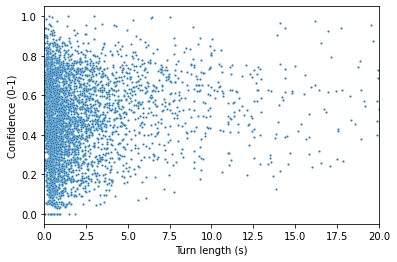

In [51]:
sp = sns.scatterplot(x=turn_lengths, y=turn_confidences, s=5)
sp.set(xlim=(0,20), xlabel="Turn length (s)", ylabel="Confidence (0-1)")

In [52]:
fig = sp.get_figure()
fig.savefig('turn_length_confidence.png', dpi=300, bbox_inches='tight')

# Correlation

In [54]:
from scipy.stats import spearmanr
spearmanr(turn_lengths, turn_confidences, nan_policy='omit')

SpearmanrResult(correlation=0.10259988151657164, pvalue=1.0023397540771997e-10)

In [27]:
pid_data = list(list(feeder.labels.items())[0][1].items())[0][1]

In [29]:
ss = get_frame_ss(pid_data['ss'])

In [30]:
mpd_data = apply_mpd(ss)
turns = get_turns(mpd_data)

In [32]:
turns[1]

[433, 818]

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt

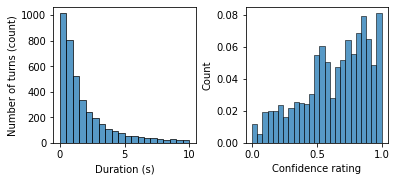

In [274]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.5))
# ax1 = fig.add_subplot(121)
sns.histplot(data=turn_lengths, binrange=[0,10], binwidth=0.5, ax=ax1)
ax1.set_xlabel("Duration (s)")
ax1.set_ylabel('Number of turns (count)')
# fig.savefig('turns.png', dpi=300, bbox_inches='tight')

# ax2 = fig.add_subplot(122)
sns.histplot(data=confidences, binrange=[0,1], binwidth=0.04, stat='probability', ax=ax2)
ax2.set_xlabel("Confidence rating")
ax2.set_ylabel('Count')
fig.subplots_adjust(wspace=0.35)
fig.savefig('ssstats.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Number of turns (count)')

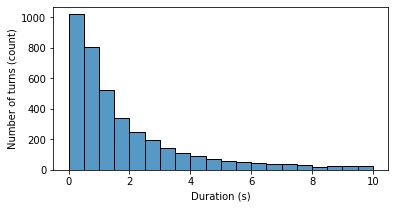

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))
sns.histplot(data=turn_lengths, binrange=[0,10], binwidth=0.5, ax=ax1)
ax1.set_xlabel("Duration (s)")
ax1.set_ylabel('Number of turns (count)')

In [28]:
fig.savefig('ssstats.png', dpi=300, bbox_inches='tight')

In [202]:
feeder.labels['vid3_seg2'][40]['conf']

,Unnamed: 0,index,media_time,data0
0,0,0.0,0.0000,0.000000
1,1,0.0,0.0000,0.000000
2,2,0.0,0.0000,0.000000
3,3,4.0,0.0547,0.485347
4,4,0.0,0.0000,0.000000
...,...,...,...,...
7195,7195,0.0,0.0000,0.000000
7196,7196,0.0,0.0000,0.000000
7197,7197,0.0,0.0000,0.000000
7198,7198,0.0,0.0000,0.000000


In [29]:
len(turn_lengths)

4096

## old-timers and newcomers

In [19]:
df = pd.read_csv('./questionnaire.csv')

In [34]:
is_newcomer = {row['ID']: bool(row['newComer']) for i, row in df.iterrows()}

In [37]:
newcomer_tls = np.concatenate([turn_lengths[k] for k in turn_lengths.keys() if is_newcomer[k]])
oldtimer_tls = np.concatenate([turn_lengths[k] for k in turn_lengths.keys() if not is_newcomer[k]])

In [38]:
(len(newcomer_tls), len(oldtimer_tls))

(1754, 2344)

In [40]:
(np.mean(newcomer_tls), np.mean(oldtimer_tls))

(2.7597871531736984, 2.6376564277588166)

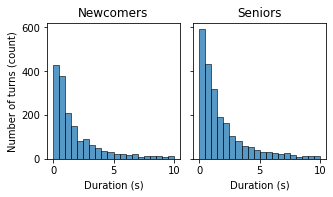

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.5), sharey=True)
sns.histplot(data=newcomer_tls, binrange=[0,10], binwidth=0.5, ax=ax1)
ax1.set_title('Newcomers')
ax1.set_xlabel("Duration (s)")
ax1.set_ylabel('Number of turns (count)')
# fig.savefig('turns.png', dpi=300, bbox_inches='tight')

sns.histplot(data=oldtimer_tls, binrange=[0,10], binwidth=0.5, ax=ax2)
ax2.set_title('Seniors')
ax2.set_xlabel("Duration (s)")
ax2.set_ylabel('Number of turns (count)')

fig.subplots_adjust(wspace=0.1)
fig.savefig('ssstats2.png', dpi=300, bbox_inches='tight')